## About
This notebook is to reconstruct the mapping from each structure to its corresponding PCA values, which can then be interpreted to get free energy values

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os
from slurmflow.serializer import ObjectSerializer
from data.data_structures.trajectory import MolecularDynamicsTrajectory
import barnaba as bb
import mdtraj as md
from einops import rearrange
from data.rna_observables import GVector
import matplotlib.pyplot as plt
%run ../PyRosetta/General.ipynb # Change path using python_libraries repo
%run ../PyRosetta/RNAFolder.ipynb
%run ../python/General.ipynb

/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pyrosetta.rosetta:Found rosetta database at: /home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/pyrosetta-2024.8+release.717d2e8-py3.10-linux-x86_64.egg/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:┌──────────────────────────────────────────────────────────────────────────────┐
│                                 P

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.08+release.717d2e8232174371f0c672564f23a097062db88a 2024-02-21T10:16:44] retrieved from: http://www.pyrosetta.org

Loaded General Python Libary


## Setup
This sets up functions to compute histograms and get FES from the program.<br/>
This is copied from from the thermomaps code. See `thermomaps-root/cli/plotting.py`

In [2]:
def compute_histograms(sim_pcs, sim_bps, gen_pcs, idx1, idx2, n_bins):
    bp_hist, bp_xedges, bp_yedges = np.histogram2d(sim_pcs[:,idx1], sim_pcs[:,idx2], bins=n_bins, density=False)
    
    bin_averages = np.zeros(bp_hist.shape)*np.nan
    for i in range(n_bins):
        for j in range(n_bins):
            # Determine which points fall into this bin
            in_bin = (sim_pcs[:, idx1] >= bp_xedges[i]) & (sim_pcs[:, idx1] < bp_xedges[i+1]) & \
                     (sim_pcs[:, idx2] >= bp_yedges[j]) & (sim_pcs[:, idx2] < bp_yedges[j+1])
            # Calculate the average of sim_bps for these points
            if in_bin.any():
                bin_averages[i, j] = np.mean(sim_bps[in_bin])

    gen_hist, gen_xedges, gen_yedges = np.histogram2d(gen_pcs[:,idx1], gen_pcs[:,idx2], bins=n_bins, density=False)
    
    with np.errstate(divide='ignore'):  # Ignore division by zero in log
        gen_hist = gen_hist/gen_hist.ravel().sum()
        FES = -np.log(gen_hist).T
        FES[np.isinf(FES)] = np.nan  # Replace infinities with NaNs
        FES -= np.nanmin(FES)
    
    # Define the center of bins to plot the contours correctly
    xcenters = (gen_xedges[:-1] + gen_xedges[1:]) / 2
    ycenters = (gen_yedges[:-1] + gen_yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)

    return bin_averages, bp_xedges, bp_yedges, X, Y, FES
def load_FES_data_from_multitraj(multitraj_path):
    OS = ObjectSerializer()
    sim_paths = [x for x in OS.get_summary(multitraj_path, depth=0) if 'sim_pca' in x]
    sim_pcs, sim_pcs_d, sim_bps, sim_bps_d = [], {}, [], {}
    for sim_path in sim_paths:
        x = OS.load(multitraj_path, internal_path=sim_path)
        sim_pcs.append(x)
        sim_pcs_d[sim_path] = x
        replica_path = 'replica' + sim_path.removeprefix('sim_pca')
        traj = OS.load(multitraj_path, internal_path=replica_path)
        sim_bps.append(traj.observables['basepairs'].quantity)
        sim_bps_d[replica_path] = traj.observables['basepairs'].quantity
    sim_pcs = np.concatenate(sim_pcs)
    sim_bps = np.concatenate(sim_bps)
    
    
    gen_paths = [x for x in OS.get_summary(multitraj_path, depth=0) if 'gen_pca' in x]
    gen_pcs, gen_pcs_d = [], {}
    for gen_path in gen_paths:
        x = OS.load(multitraj_path, internal_path=gen_path)
        gen_pcs.append(x)
        gen_pcs_d[gen_path] = x
    gen_pcs = np.concatenate(gen_pcs)

    frames = OS.load(multitraj_path, internal_path='resampled_seeds')
    ipca = OS.load(multitraj_path, internal_path='ipca')
    
    gv = GVector()
    seed_pcs, seed_temps = [], []
    for frame in frames:
        single_sample = gv.evaluate(frame.md_traj)
        single_sample = rearrange(single_sample, 'b h w c -> b c h w')
        proj = ipca.transform(single_sample.reshape(1,-1))
        seed_pcs.append(proj)
        seed_temps.append(frame.state_variables.temperature)
    seed_pcs = np.concatenate(seed_pcs)
    seed_temps = np.array(seed_temps)
    
    return sim_pcs, sim_pcs_d, sim_bps, gen_pcs, gen_pcs_d, seed_pcs, seed_temps
def plot_FES(multitraj_path, output_dir, idx1, idx2, n_bins=40, n_levels=10):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    sim_pcs, sim_pcs_d, sim_bps, gen_pcs, gen_pcs_d, seed_pcs, seed_temps = load_FES_data_from_multitraj(multitraj_path)

    # Calculate the number of plots and rows needed
    num_keys = len(gen_pcs_d.keys())
    num_rows = (num_keys + 3) // 4  # Add 3 and integer divide by 4 to ensure rounding up if there's a remainder
    scale=2
    fig, axs = plt.subplots(num_rows, 4, figsize=(60/scale, 10*num_rows/scale), dpi=400)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # If the number of keys is not a multiple of 4, adjust the last row to have fewer plots
    if num_keys % 4:
        for ax in axs.flat[num_keys:]:
            ax.axis('off')  # Hide unused axes

    temp_FES=dict()
    for i, (key, ax) in enumerate(zip(gen_pcs_d.keys(), axs.flat)):
        temp = key.removeprefix('gen_pca')
        temp_int = int(temp.removesuffix('K'))
    
        seed_pcs_ = seed_pcs[seed_temps == temp_int]
        
        bin_averages, bp_xedges, bp_yedges, X, Y, FES = compute_histograms(sim_pcs, sim_bps, gen_pcs_d[key], idx1, idx2, n_bins=n_bins)
        temp_FES[key]=(bin_averages,X,Y,FES,bp_xedges,bp_yedges)

        im = ax.imshow(bin_averages.T, extent=[bp_xedges[0], bp_xedges[-1], bp_yedges[0], bp_yedges[-1]], origin='lower', aspect='auto', cmap='binary')
        ax.scatter(seed_pcs_[:,idx1], seed_pcs_[:,idx2], marker='*', color='g', edgecolor='k', s=70, zorder=3)
        fig.colorbar(im, ax=ax, location='left', label='Base Pairs')
        cp = ax.contour(X, Y, FES, levels=n_levels, cmap='YlOrBr')  # Transpose FES for correct orientation
        fig.colorbar(cp, ax=ax, label='Free Energy')
        ax.set_xlabel(fr'PC$_{idx1}$')
        ax.set_ylabel(fr'PC$_{idx2}$')
        ax.set_title(f'FES ({temp})')
        
    plt.tight_layout()
    plt.show()
    output_filename = os.path.join(output_dir, f"FES_PCA_{idx1}{idx2}.png")
    plt.savefig(output_filename, dpi=400)
    return temp_FES

### Local parameters and selecting the iteration

In [3]:
ROOT_DIR="/home/venkata/python/PyRosetta/R1107/server/example5/iter0/" # TODO: Change Accordingly (Select the correct path and pick the iteration you want to run the analysis for)

# Constructing the object serializer to load saved objects
OS = ObjectSerializer()

# Read all headers in the saved file
headers = OS.get_summary(ROOT_DIR+"/multitraj.h5", depth=0)
print(headers)

# This will print all the "headers" available in the saved file

['MLF', 'gen_pca300K', 'gen_pca325K', 'gen_pca350K', 'gen_pca375K', 'gen_sampler300K', 'gen_sampler325K', 'gen_sampler350K', 'gen_sampler375K', 'ipca', 'replica0', 'replica1', 'replica10', 'replica11', 'replica12', 'replica13', 'replica14', 'replica16', 'replica17', 'replica2', 'replica3', 'replica4', 'replica5', 'replica6', 'replica7', 'replica8', 'replica9', 'resampled_seeds', 'sim_pca0', 'sim_pca1', 'sim_pca10', 'sim_pca11', 'sim_pca12', 'sim_pca13', 'sim_pca14', 'sim_pca16', 'sim_pca17', 'sim_pca2', 'sim_pca3', 'sim_pca4', 'sim_pca5', 'sim_pca6', 'sim_pca7', 'sim_pca8', 'sim_pca9', 'sim_sampler']


### Loading relavent files

#### Important note
Sometimes `multitraj.h5` will be found as `iterxxx/mount/multitraj.h5`. In that case, manually, move the multitraj folder one step back to `iterxxx/multitraj.h5`

In [4]:
# Select the multitraj file
multitraj_path=ROOT_DIR+"/multitraj.h5"

# Load the PCA
the_PCA=OS.load(multitraj_path,"ipca")

# Representation used in PCA (G-vectors)
gv = GVector()

## Data generation
Construct the PCA vectors and save after attaching RMSD data<br/>

**Note:** You do not need to run the next 2 cells if you've already run them once for the chosen `ROOT_DIR` folder

In [5]:
# Load all the clusters from the xtc directory
clustfol=ROOT_DIR+"/mount/xtc/"

# Sort it so that the order is fixed.
# NOTE: This is NOT a numeric sort. It is a text sort, so file 'cluster10.xtc' will appear before 'cluster2.xtc'. The goal is to just get a reproducable order, not the numerical order
clusters=sorted([fol for fol in os.listdir(clustfol) if fol.endswith(".xtc")])

# Iterate over the cluster
for cl in clusters:
    clid=cl.replace("cluster","").replace(".xtc","")
    # Load the cluster
    mdtraj=md.load(clustfol+"/"+cl,top=clustfol+"/top.pdb")

    # Construct PCA data for every frame (structure) in that cluster
    pca_data=[]
    for frame in mdtraj:
        constructed_traj=MolecularDynamicsTrajectory(None,None,frame)
        single_sample=gv.evaluate(constructed_traj.md_traj)
        single_sample=rearrange(single_sample, 'b h w c -> b c h w')
        proj = the_PCA.transform(single_sample.reshape(1,-1))
        pca_data.append(proj)
    pca_data=np.concatenate(pca_data,axis=0)

    # Save to a numpy data file
    np.save(clustfol+"/pca_"+clid+".npy",pca_data)
    print("Saved to",clustfol+"/pca_"+clid+".npy",flush=True)

Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_-1.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_0.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_1.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_10.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_11.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_12.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_2.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_3.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_4.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_5.npy
Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//mount/xtc//pca_6.npy
Saved 

#### RMSD <-> PCA mapping
**Note:** Before running this, you need to have run `TMaMD_PostProcess.ipynb` using the crystal structure as the reference. This will generate the RMSD data.

In [8]:
pca_rmsd_map=[]
all_rmsd_data=np.load(ROOT_DIR+"cluster_rmsds.npy",allow_pickle=True)
cluster_ids=np.load(ROOT_DIR+"cluster_ids.npy")
for cl in clusters:
    clid=cl.replace("cluster","").replace(".xtc","")

    # Load the (previously computed) PCA data
    pca_data=np.load(clustfol+"/pca_"+clid+".npy")
    idx=np.where(cluster_ids==cl)[0].item()

    # Load the RMSD data
    rmsd_data=np.array(all_rmsd_data[idx])

    # Combine PCA and RMSD data into one
    comb=np.concatenate((pca_data,rmsd_data[:,np.newaxis]),axis=-1)
    index_data=np.ones(len(comb))*idx

    # Write out the cluster INDEX number into the array as well so we don't have to go back to find it later
    # NOTE: This is not the same as cluster number. This is the index of the cluster in the list
    comb=np.concatenate((comb,index_data[:,np.newaxis]),axis=-1)
    pca_rmsd_map.append(comb)
pca_rmsd_map=np.concatenate(pca_rmsd_map,axis=0)
np.save(ROOT_DIR+"/pca_rmsd_mapping.npy",pca_rmsd_map)
print("Saved to",ROOT_DIR+"/pca_rmsd_mapping.npy")

Saved to /home/venkata/python/PyRosetta/R1107/server/example5/iter0//pca_rmsd_mapping.npy


### Analysis part
You don't need to run the data generation section (previous 2 cells) if you have already run them once and want to do the analysis

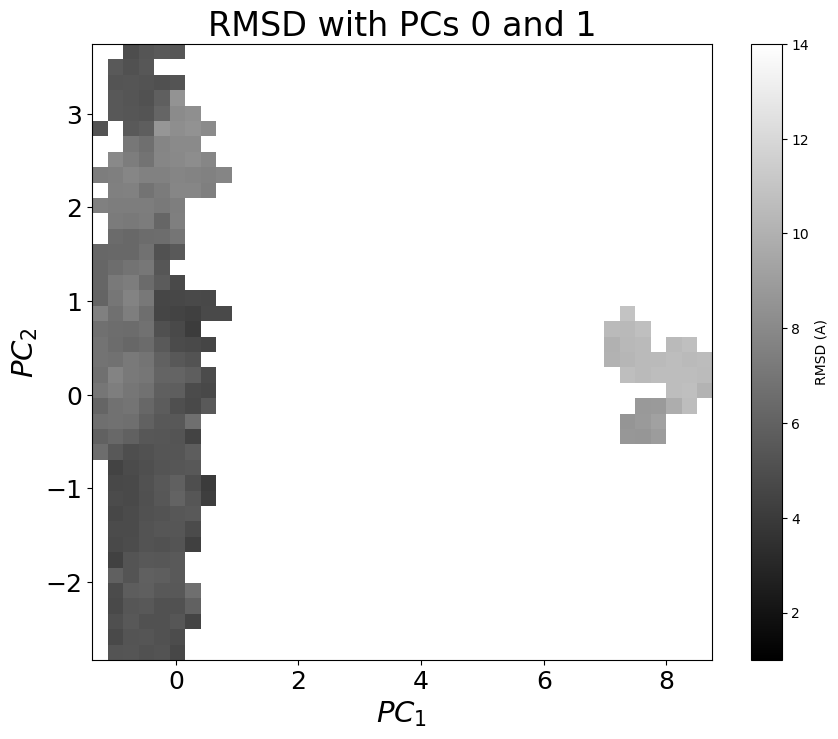

In [6]:
all_rmsd_data=np.load(ROOT_DIR+"cluster_rmsds.npy",allow_pickle=True)
cluster_ids=np.load(ROOT_DIR+"cluster_ids.npy")
pca_rmsd_map=np.load(ROOT_DIR+"/pca_rmsd_mapping.npy")

n_bins=40
idx1,idx2=0,1
sim_bps=pca_rmsd_map[:,-2]
hg,bp_xedges,bp_yedges=np.histogram2d(pca_rmsd_map[:,idx1],pca_rmsd_map[:,idx2],bins=n_bins,density=False)
bin_averages = np.zeros(hg.shape)*np.nan
for i in range(n_bins):
    for j in range(n_bins):
        # Determine which points fall into this bin
        in_bin = (pca_rmsd_map[:, idx1] >= bp_xedges[i]) & (pca_rmsd_map[:, idx1] < bp_xedges[i+1]) & \
                 (pca_rmsd_map[:, idx2] >= bp_yedges[j]) & (pca_rmsd_map[:, idx2] < bp_yedges[j+1])
        if in_bin.any(): bin_averages[i, j] = np.mean(sim_bps[in_bin])

def plot_RMSD_over_PCA():
    plt.figure(figsize=(10,8))
    plt.imshow(bin_averages.T,extent=[bp_xedges[0], bp_xedges[-1], bp_yedges[0], bp_yedges[-1]], origin='lower', aspect='auto', cmap='binary_r',vmin=1,vmax=28) # TODO: Change Accordingly (Change vmin and vmax to get a good looking plot. It sets the scale of the RMSD colorbar)
    plt.colorbar(label="RMSD (A)")
    plt.title("RMSD with PCs 0 and 1",fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("$PC_1$",fontsize=21)
    plt.ylabel("$PC_2$",fontsize=21)

plot_RMSD_over_PCA() # TODO: Change accordingly (You can comment out this line if you don't want the plot)

In [7]:
# Find the RMSD of the closest bin (not the same as the lowest RMSD structure)
bin_averages[np.isnan(bin_averages)]=np.inf
min_idx=np.unravel_index(np.argmin(bin_averages),(n_bins,n_bins))
print("RMSD=",bin_averages[min_idx],"at index:",min_idx)

RMSD= 4.027197595200648 at index: (7, 11)


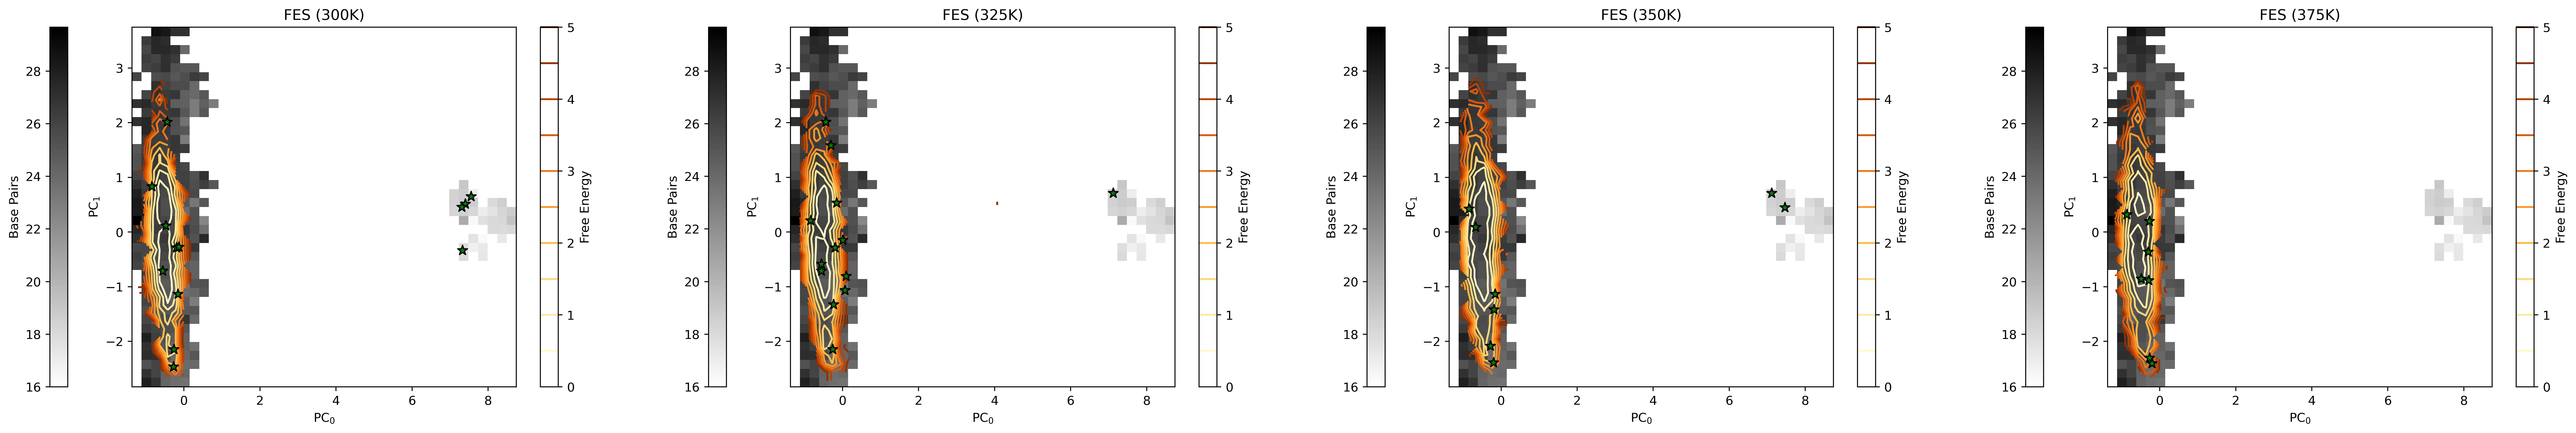

<Figure size 640x480 with 0 Axes>

In [8]:
# Compute the Free-Energy surface from the replicas in this iteration. The results will be written to the path specified (an image)
my_FES=plot_FES(multitraj_path,"/home/venkata/dump",0,1) #TODO: Change accordingly (Pick a path where you want the FES image to be saved)

### Comparison
Make a side-by-side plot of RMSD and FES on the same PCs

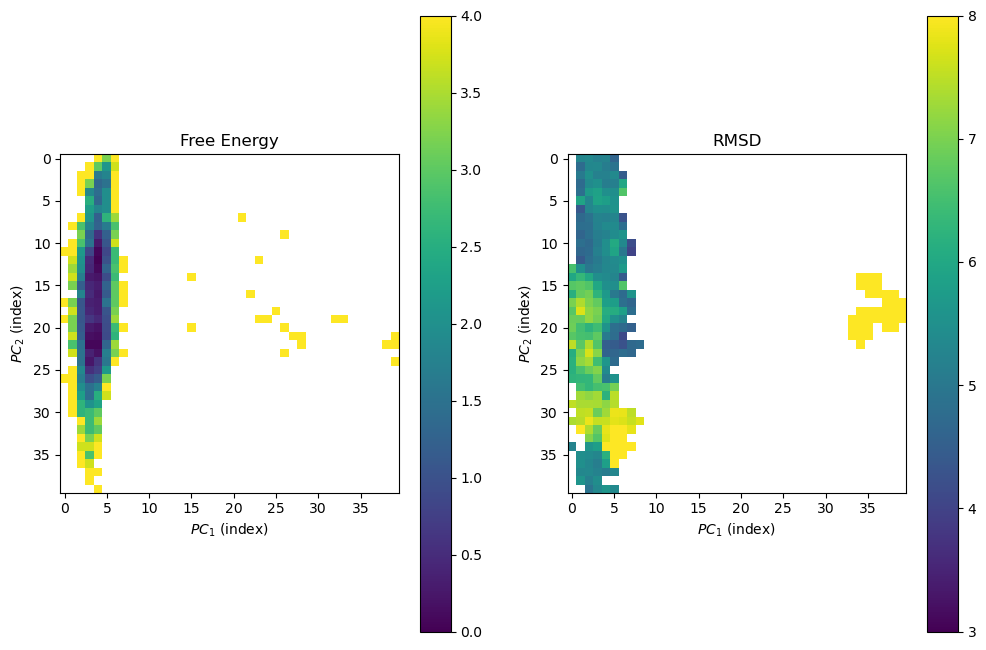

In [9]:
TEMP="gen_pca300K" #TODO: Change Accordingly (Plot at this temperature - Default: 300 K)
copied_FES=my_FES[TEMP][3].copy()
copied_RMSD=bin_averages.copy().T

plt.figure(figsize=(12,8))
x_ticks=((bp_xedges[1:]+bp_xedges[:-1])/2)
x_ticks=x_ticks[::len(x_ticks)//2]

plt.subplot(1,2,1)
plt.imshow(copied_FES,vmin=0,vmax=4) # TODO: Change accordingly (vmin and vmax are the upper and lower limits on the colorbar. Choosing these values nicely can highlight deep/shallow regions of the surface)
plt.xlabel("$PC_1$ (index)")
plt.ylabel("$PC_2$ (index)")
plt.colorbar()
plt.title("Free Energy")
plt.subplot(1,2,2)
plt.imshow(copied_RMSD,vmin=3,vmax=8) # TODO: Change accordingly (vmin and vmax are the upper and lower limits on the colorbar. Choosing these values nicely can highlight deep/shallow regions of the surface)
plt.xlabel("$PC_1$ (index)")
plt.ylabel("$PC_2$ (index)")
plt.title("RMSD")
#plt.xticks(np.arange(n_bins)[::n_bins//2],x_ticks)
plt.colorbar()
plt.savefig(ROOT_DIR+"/mount/figs/RMSD_FES_comparison.png")

### Converting FES into a GriddedData object

In [10]:
# Pick the FES grid object at the chosen temperature
copied_FES=my_FES[TEMP][3].copy()

# Safety check to make sure that the values of the PCs in both plots are close enough (Should say 'True','True')
np.all(np.abs(my_FES[TEMP][-2]-bp_xedges)<5e-3),np.all(np.abs(my_FES[TEMP][-1]-bp_yedges)<5e-3)

(True, True)

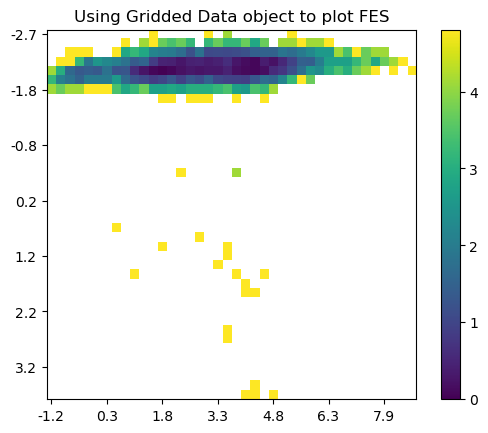

In [11]:
gdat=GriddedData(copied_FES,my_FES[TEMP][4].copy(),my_FES[TEMP][5].copy(),x_bounded=True,y_bounded=True)
gdat.draw(plt)
plt.title("Using Gridded Data object to plot FES")
plt.show()

# Note: Plot should look same as the above FES plot, except that it is transposed (X-Y flipped)

### Plot FES vs RMSD cluster-wise

In [12]:
clids=np.unique(pca_rmsd_map[:,-1])
clFE=[]
for clid in clids:
    fevals=[]
    for pose_pca in pca_rmsd_map[pca_rmsd_map[:,-1]==clid][:,(0,1)]:
        try:
            FE=gdat[pose_pca]
        except ValueError: continue
        if np.isnan(FE): continue
        fevals.append(FE)
    if len(fevals):
        fevals=np.array(fevals)
        fewts=np.exp(-fevals)
        fewted=np.nansum(fevals*fewts)/np.nansum(fewts)
        print(clid,"has a computed Free Energy")
        clFE.append(np.nanmean(fewted))
    else:
        clFE.append(np.nan)
clFE=np.array(clFE)

3.0 has a computed Free Energy
8.0 has a computed Free Energy
10.0 has a computed Free Energy
12.0 has a computed Free Energy


In [13]:
clusterwise_FE=[]
clusterwise_RMSD=[]
for i,FE in enumerate(clFE):
    if np.isnan(FE): continue
    RMSD=np.min(all_rmsd_data[i])
    clusterwise_FE.append(FE)
    clusterwise_RMSD.append(RMSD)
clusterwise_FE=np.array(clusterwise_FE)
clusterwise_RMSD=np.array(clusterwise_RMSD)
print("Minimum RMSD:",clusterwise_RMSD[np.argmin(clusterwise_RMSD)])

Minimum RMSD: 3.07260896167864


Text(0, 0.5, 'Min of RMSD for cluster')

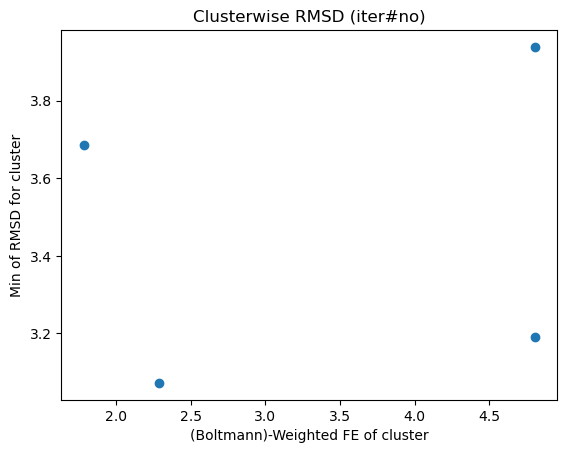

In [14]:
plt.title("Clusterwise RMSD (iter#no)") # TODO: Change accordingly (Replace #no with the appropriate iteration number)
plt.scatter(clusterwise_FE,clusterwise_RMSD)
plt.xlabel("(Boltmann)-Weighted FE of cluster")
plt.ylabel("Min of RMSD for cluster")